In [1]:
# inversion calculation

In [2]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
import pandas as pd
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [4]:
name_month = 'Mar' # Jan, Feb, Mar
imonth     =  3    # 1,2,3
mode       = 'N'  # 'N': Nadir or 'NG': Nadir + Glint

In [5]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_directory = input_directory

if mode == 'N':
    delta_y0_file = 'delta_y0_model_N_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
else:
    delta_y0_file = 'delta_y0_model_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'

In [6]:
ds_delta_y0 = xr.open_dataset(input_directory + delta_y0_file)
varnames = list(ds_delta_y0.data_vars.keys())

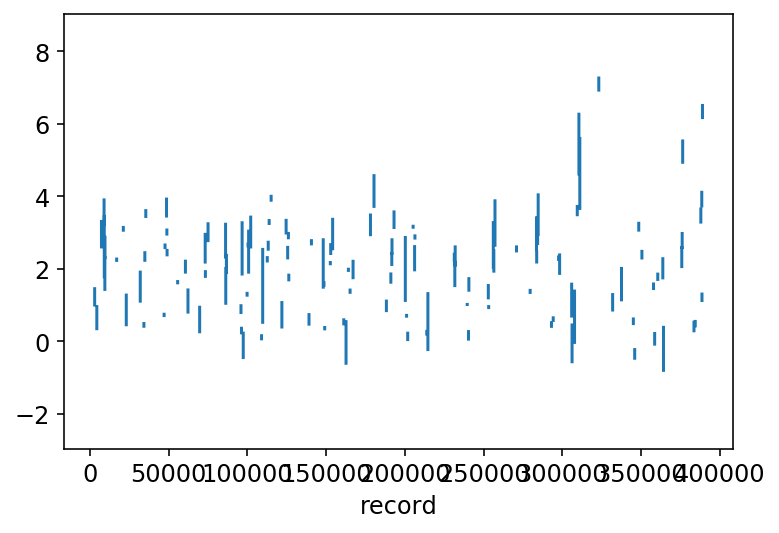

In [7]:
ds_xco2 = xr.open_dataset(input_directory + xco2_file)
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
diff.plot()

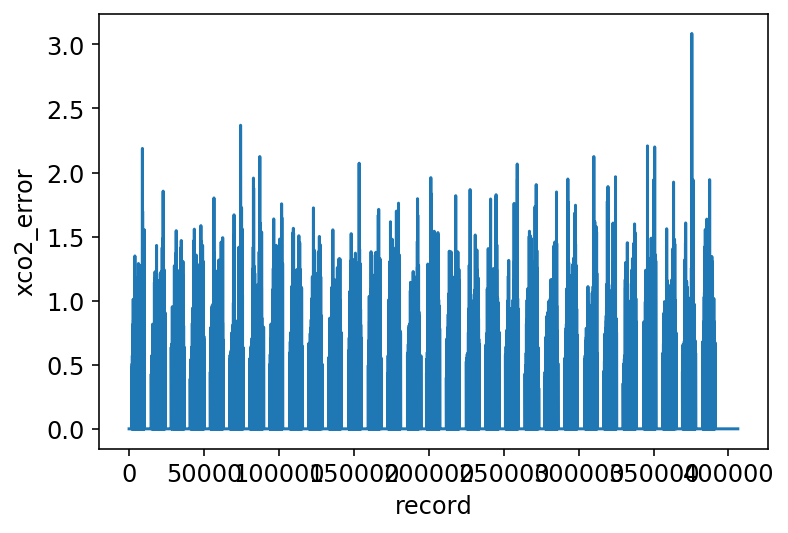

In [8]:
xco2_error = ds_xco2['xco2_error']
xco2_error.plot()

In [9]:
# reduce the size of all arrays and matrices, from 400k to <10k
xco2_oco2 = ds_xco2['xco2_oco2']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values # index for slicing
length = len(ind)
length

1487

(1487,)


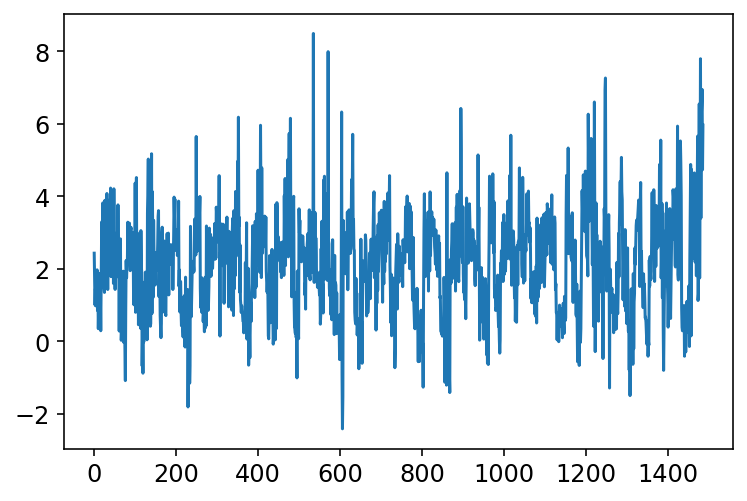

In [10]:
diff_slice = diff[ind].values
print(np.shape(diff_slice))
plt.plot(diff_slice) # same as above, excluded nan values

1487


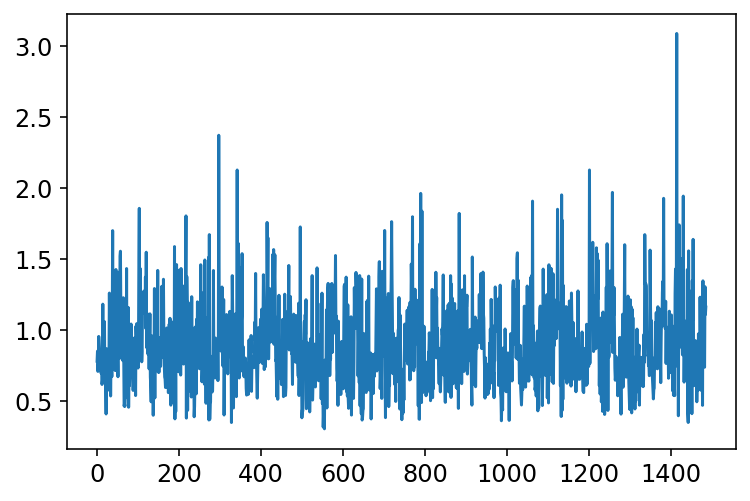

In [11]:
xco2_error_slice = xco2_error[ind].values
print(len(xco2_error_slice))
plt.plot(xco2_error_slice) # same as above, excluded nan values

In [12]:
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
print(np.shape(del_Y_matrix))

for itag in range(22):
    name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values

(1487, 22)


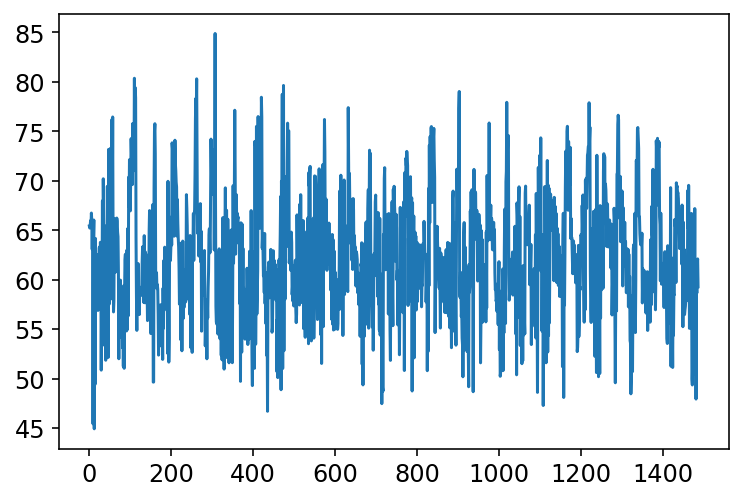

In [13]:
plt.plot(del_Y_matrix[:,5])

In [14]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first = np.matmul(del_Y_matrix,del_Y_tran)
print(np.shape(first))
first

(1487, 1487)


array([[94058.88660088, 93756.67338926, 94091.37565876, ...,
        88806.23087286, 89156.08920378, 85354.76711894],
       [93756.67338926, 93455.43120386, 93789.05807615, ...,
        88520.89445478, 88869.62905431, 85080.52035329],
       [94091.37565876, 93789.05807615, 94123.87597249, ...,
        88836.90526474, 89186.88530455, 85384.24939416],
       ...,
       [88806.23087286, 88520.89445478, 88836.90526474, ...,
        83859.38646036, 84177.46651869, 80599.86890734],
       [89156.08920378, 88869.62905431, 89186.88530455, ...,
        84177.46651869, 84508.89830873, 80905.8936333 ],
       [85354.76711894, 85080.52035329, 85384.24939416, ...,
        80599.86890734, 80905.8936333 , 77467.05310012]])

In [15]:
obs_error = np.zeros((length,length))
print(np.shape(obs_error))
for idiag in range(length):
    obs_error[idiag, idiag] = xco2_error_slice[idiag] + 2.5 #random_error[idiag]
obs_error

(1487, 1487)


array([[3.27951968, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.35063207, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.20771402, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.80382001, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.607705  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.66034412]])

In [16]:
second = np.linalg.inv(first+obs_error)
second

array([[ 3.04542731e-01, -3.66293790e-04, -3.79243396e-04, ...,
         1.51606400e-04, -4.38103442e-05,  1.49469740e-04],
       [-3.66293790e-04,  2.98097770e-01, -3.66128103e-04, ...,
         1.46632346e-04, -4.62842080e-05,  1.44013962e-04],
       [-3.79243396e-04, -3.66128103e-04,  3.11368894e-01, ...,
         1.52257860e-04, -5.20008917e-05,  1.48961316e-04],
       ...,
       [ 1.51606400e-04,  1.46632346e-04,  1.52257860e-04, ...,
         2.52897586e-01, -1.25911162e-04, -9.74015372e-03],
       [-4.38103441e-05, -4.62842076e-05, -5.20008914e-05, ...,
        -1.25911162e-04,  2.76081662e-01, -9.44445885e-05],
       [ 1.49469740e-04,  1.44013962e-04,  1.48961317e-04, ...,
        -9.74015372e-03, -9.44445884e-05,  2.63700836e-01]])

In [17]:
third = np.matmul(del_Y_tran,second)
print(np.shape(third))
third

(22, 1487)


array([[-3.81897605e-04, -3.54986685e-04, -3.66157600e-04, ...,
         4.14644180e-04, -1.69423970e-03,  2.77930826e-04],
       [ 7.45117035e-04,  7.34504478e-04,  7.60026341e-04, ...,
         1.05194267e-04, -1.40137874e-03,  5.99685063e-05],
       [ 1.23714046e-04, -8.99207007e-05, -1.62428956e-04, ...,
         3.53967101e-04, -1.58598338e-03,  2.42086719e-04],
       ...,
       [ 6.11968806e-04,  6.15539810e-04,  6.54438187e-04, ...,
         5.82245398e-04, -1.56499747e-03,  1.66686307e-03],
       [ 8.23124670e-04,  8.21451940e-04,  8.71665176e-04, ...,
        -7.67583640e-04, -4.24799154e-03,  1.09806322e-04],
       [ 1.41988754e-03,  1.39094998e-03,  1.45080705e-03, ...,
        -5.92015786e-04, -4.32301262e-05, -6.92335973e-04]])

In [18]:
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0  #/21 # GrC/yr

In [19]:
k_e = np.matmul(del_X_f,third)
print(np.shape(k_e))
k_e

(22, 1487)


array([[-3.81897605e-04, -3.54986685e-04, -3.66157600e-04, ...,
         4.14644180e-04, -1.69423970e-03,  2.77930826e-04],
       [ 7.45117035e-04,  7.34504478e-04,  7.60026341e-04, ...,
         1.05194267e-04, -1.40137874e-03,  5.99685063e-05],
       [ 1.23714046e-04, -8.99207007e-05, -1.62428956e-04, ...,
         3.53967101e-04, -1.58598338e-03,  2.42086719e-04],
       ...,
       [ 6.11968806e-04,  6.15539810e-04,  6.54438187e-04, ...,
         5.82245398e-04, -1.56499747e-03,  1.66686307e-03],
       [ 8.23124670e-04,  8.21451940e-04,  8.71665176e-04, ...,
        -7.67583640e-04, -4.24799154e-03,  1.09806322e-04],
       [ 1.41988754e-03,  1.39094998e-03,  1.45080705e-03, ...,
        -5.92015786e-04, -4.32301262e-05, -6.92335973e-04]])

In [20]:
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values
prior_emission = df['emission'].values

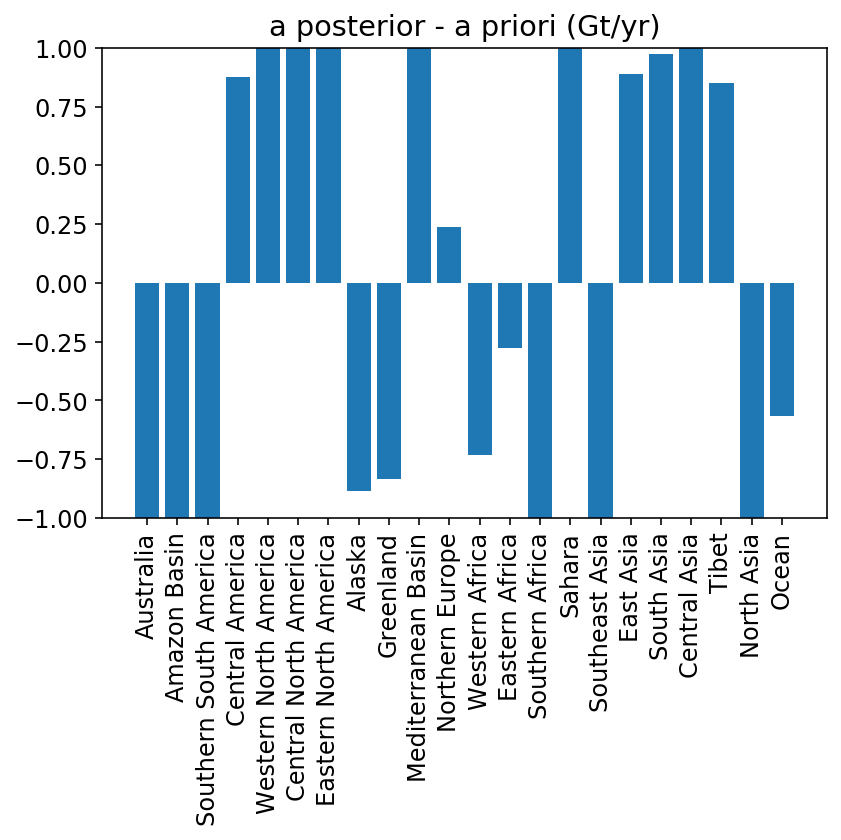

In [21]:
adjust = np.matmul(k_e, diff_slice)

fig = plt.figure(figsize=[6, 6])
plt.bar(region_names, adjust)
plt.ylim(top   = 1,bottom = -1)
plt.title('a posterior - a priori (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'adjustment_' + name_month +'.png', dpi=300)

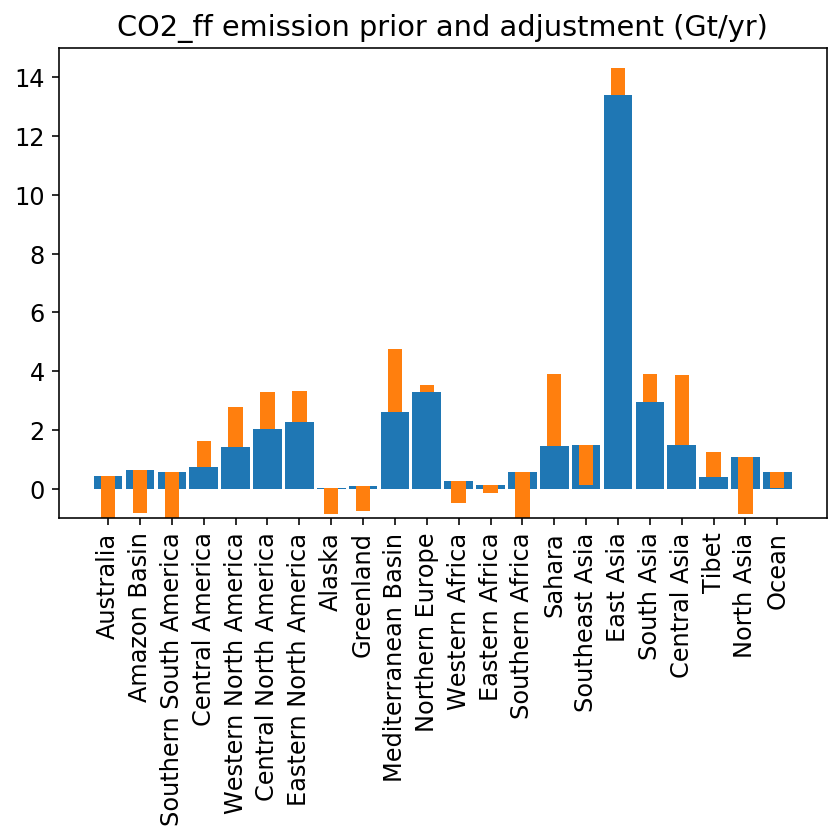

In [22]:
fig = plt.figure(figsize=[6, 6])
width = 0.9
plt.bar(region_names, prior_emission, width)
plt.bar(region_names, adjust,         width*0.5, bottom = prior_emission)
plt.ylim(top   = 15,bottom = -1)
plt.title('CO2_ff emission prior and adjustment (Gt/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'posterior_' + name_month +'.png', dpi=300)